## Clustering the images from the dataset

### Installing requirements

In [0]:
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import numpy as np
from sklearn.cluster import KMeans
import os, shutil, glob, os.path
from PIL import Image as pil_image
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [0]:
# loading pretrained VGG16 model 
image.LOAD_TRUNCATED_IMAGES = True 
model = VGG16(weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 6s 0us/step


### Getting to work

In [0]:
# extracting the paths 
info_path = "/content/drive/My Drive/AttnGAN/data/wikiart/wikiartinfo.csv"
image_df = pd.read_csv(info_path)

In [0]:
# fixing some stuff that's wrong with the paths 
# (i.e. '..jpg' or '.jpeg' to '.jpg)
for path in image_df['path'].tolist():
  if path[-4:] != '.jpg':
    print(path)
    newpath = path[:-4] + ".jpg"
    image_df = image_df.replace(path, newpath)

for path in image_df['path'].tolist():
  if path[-5] == '.':
    print(path)
    newpath = path[:-5] + ".jpg"
    print(newpath)
    image_df = image_df.replace(path, newpath) 

In [0]:
paths = image_df['path'].tolist()
begin_path = '/content/drive/My Drive/AttnGAN/data/wikiart/images'

fullpaths = []
for path in paths:
  fullpath = begin_path + path
  fullpaths.append(fullpath)
print(paths[:5])
print(fullpaths[:5])
print(len(fullpaths))

['/impressionism/in-the-luxembourg-garden-1889.jpg', '/neo_expressionism/the-marriage-of-heaven-and-hell-1984.jpg', '/post_impressionism/uncle-piacsek-in-front-of-the-black-sideboard-1906.jpg', '/cubism/monk-for-the-play-mazeppa-1920.jpg', '/romanticism/the-defence-of-sarago-a.jpg']
['/content/drive/My Drive/AttnGAN/data/wikiart/images/impressionism/in-the-luxembourg-garden-1889.jpg', '/content/drive/My Drive/AttnGAN/data/wikiart/images/neo_expressionism/the-marriage-of-heaven-and-hell-1984.jpg', '/content/drive/My Drive/AttnGAN/data/wikiart/images/post_impressionism/uncle-piacsek-in-front-of-the-black-sideboard-1906.jpg', '/content/drive/My Drive/AttnGAN/data/wikiart/images/cubism/monk-for-the-play-mazeppa-1920.jpg', '/content/drive/My Drive/AttnGAN/data/wikiart/images/romanticism/the-defence-of-sarago-a.jpg']
3894


In [0]:
# Loop over files and get their features

featurelist = []
for i, imagepath in enumerate(fullpaths):
    print("    Status: %s / %s" %(i, len(fullpaths)), end="\r")
    img = image.load_img(imagepath, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    features = np.array(model.predict(img_data))
    featurelist.append(features.flatten())

In [0]:
# saving the list of features to access later
print(len(featurelist))
np.save('/content/drive/My Drive/AttnGAN/data/wikiart/imagefeatures.npy', featurelist)

3894
3894


In [0]:
featurelist = np.load('/content/drive/My Drive/AttnGAN/data/wikiart/imagefeatures.npy')

In [0]:
# elbow method to see what is a nice amount of clusters
# from: https://www.kaggle.com/ellecf/visualizing-multidimensional-clusters    
inertia = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(np.array(featurelist))
    kmeanModel.fit(np.array(featurelist))
    inertia.append(kmeanModel.inertia_)

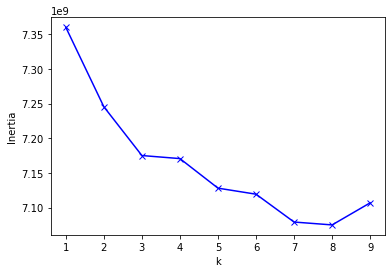

In [0]:
# Plot the elbow
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

In [0]:
# the elbow method here is pretty vague, 
# let's pick 5?? 
kmeans = KMeans(n_clusters=5, random_state=0).fit(np.array(featurelist))

In [0]:
# save the label prediction of the kmeans clustering
print(len(kmeans.labels_))
np.save('/content/drive/My Drive/AttnGAN/data/wikiart/kmeans_labels.npy', kmeans.labels_)

3894


In [0]:
labels = np.load('/content/drive/My Drive/AttnGAN/data/wikiart/kmeans_labels.npy')

### Cluster visualisation
Since the clusters consist of clusters in high-dimensional space, we need to first transform them to 2d-space in order to visualise them. I will use PCA for this. 

In [0]:
print(featurelist[:5], "\n", labels[:5], "\n", fullpaths[:5])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 
 [1 3 2 3 1] 
 ['/content/drive/My Drive/AttnGAN/data/wikiart/images/impressionism/in-the-luxembourg-garden-1889.jpg', '/content/drive/My Drive/AttnGAN/data/wikiart/images/neo_expressionism/the-marriage-of-heaven-and-hell-1984.jpg', '/content/drive/My Drive/AttnGAN/data/wikiart/images/post_impressionism/uncle-piacsek-in-front-of-the-black-sideboard-1906.jpg', '/content/drive/My Drive/AttnGAN/data/wikiart/images/cubism/monk-for-the-play-mazeppa-1920.jpg', '/content/drive/My Drive/AttnGAN/data/wikiart/images/romanticism/the-defence-of-sarago-a.jpg']


In [0]:
categories = image_df["Category"].tolist()

['Impressionism',
 'Neo-Expressionism',
 'Post-Impressionism',
 'Cubism',
 'Romanticism']

In [0]:
# create a seperate df from those lists
label_df = pd.DataFrame(labels, columns = ["label"])
cat_df = pd.DataFrame(categories, columns = ["category"])

In [0]:
# scale the features for PCA
x = StandardScaler().fit_transform(featurelist)

In [0]:
x[:5]

array([[-0.18367034, -0.11205526, -0.16582227, ..., -0.15479206,
        -0.38724867, -0.2052646 ],
       [-0.18367034, -0.11205526, -0.16582227, ..., -0.15479206,
        -0.38724867, -0.2052646 ],
       [-0.18367034, -0.11205526, -0.16582227, ..., -0.15479206,
        -0.38724867, -0.2052646 ],
       [-0.18367034, -0.11205526, -0.16582227, ..., -0.15479206,
        -0.38724867, -0.2052646 ],
       [-0.18367034, -0.11205526, -0.16582227, ..., -0.15479206,
        -0.38724867, -0.2052646 ]], dtype=float32)

In [0]:
# apply PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

In [0]:
# save the pca features in a new dataframe
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head()

,principal component 1,principal component 2
0,-4.034986,-19.415449
1,-30.805895,9.753323
2,20.272789,14.968486
3,-17.230186,17.681522
4,25.080841,-27.534513


In [0]:
# add the labels to this df
finalDf = pd.concat([principalDf, label_df["label"]], axis = 1)
finalDf

,principal component 1,principal component 2,label
0,-4.034986,-19.415449,1
1,-30.805895,9.753323,3
2,20.272789,14.968486,2
3,-17.230186,17.681522,3
4,25.080841,-27.534513,1
...,...,...,...
3889,-24.611660,8.188285,3
3890,11.062795,-14.717443,1
3891,-11.548306,1.761003,3
3892,29.797844,-0.256068,1


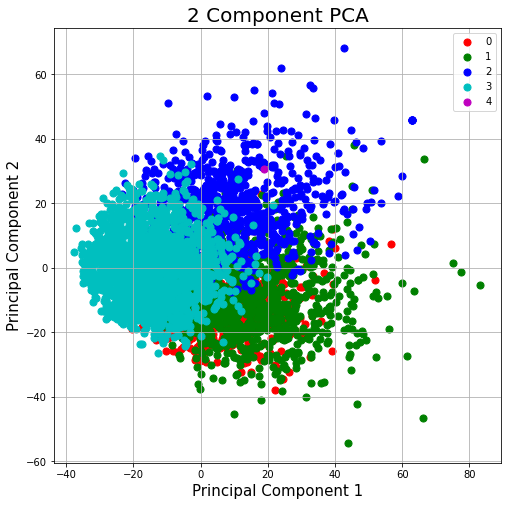

In [0]:
# visualisation
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)


targets = [0, 1, 2, 3, 4]
colors = ['r', 'g', 'b', 'c', 'm']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [0]:
# concatenate the categories to the df
other_df = pd.concat([principalDf, categories["category"]], axis = 1)

,principal component 1,principal component 2,category
0,-4.034986,-19.415449,Impressionism
1,-30.805895,9.753323,Neo-Expressionism
2,20.272789,14.968486,Post-Impressionism
3,-17.230186,17.681522,Cubism
4,25.080841,-27.534513,Romanticism
...,...,...,...
3889,-24.611660,8.188285,Color Field Painting
3890,11.062795,-14.717443,Surrealism
3891,-11.548306,1.761003,Neo-Expressionism
3892,29.797844,-0.256068,Expressionism


In [0]:
# first have to filter out some that have multiple categories, 
# and just place them in their first category
new_cats = []
for category in image_df["Category"]:
  first_cat = category.rsplit(',')[0]
  new_cats.append(first_cat)
categories = pd.DataFrame(new_cats, columns = ["category"])

In [0]:
# list the amount og unique categories
unique_categories = cat_df["category"].unique().tolist()
unique_cats = []
for category in unique_categories:
  first_cat = category.rsplit(',')[0] # only take the first category (some have multiple)
  if first_cat not in unique_cats:
    unique_cats.append(first_cat)
print(unique_cats)
len(unique_cats)

['Impressionism', 'Neo-Expressionism', 'Post-Impressionism', 'Cubism', 'Romanticism', 'Expressionism', 'Realism', 'Minimalism', 'Pop Art', 'Rococo', 'Color Field Painting', 'Early Renaissance', 'Art Informel', 'Baroque', 'Abstract Art', 'Lyrical Abstraction', 'Surrealism', 'Abstract Expressionism', 'Magic Realism', 'Northern Renaissance', 'Neoclassicism', 'High Renaissance']


22

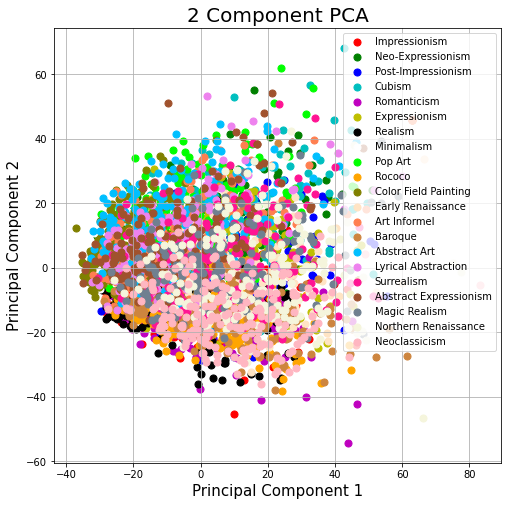

In [0]:
# visualising the clusters, labeled with their category
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'lime', 'orange',
          'olive', 'bisque', 'coral', 'peru', 'deepskyblue', 'violet',
          'deeppink', 'sienna', 'slategray', 'beige', 'lightpink' ]
for category, color in zip(unique_cats,colors):
    indicesToKeep = other_df['category'] == category
    ax.scatter(other_df.loc[indicesToKeep, 'principal component 1']
               , other_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(unique_cats)
ax.grid()

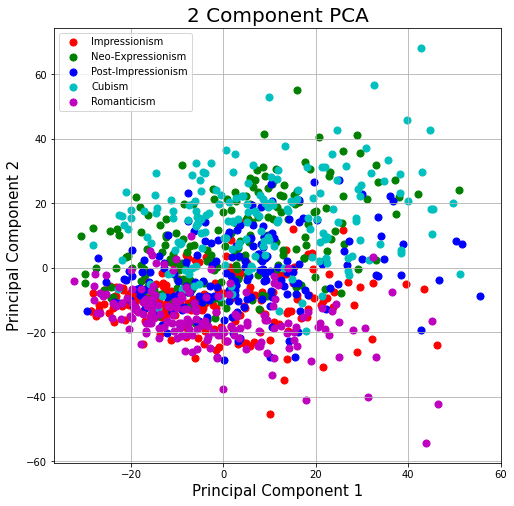

In [0]:
# now for 5 categories per graph
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

colors = ['r', 'g', 'b', 'c', 'm']
for category, color in zip(unique_cats[:5],colors):
    indicesToKeep = other_df['category'] == category
    ax.scatter(other_df.loc[indicesToKeep, 'principal component 1']
               , other_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(unique_cats[:5])
ax.grid()

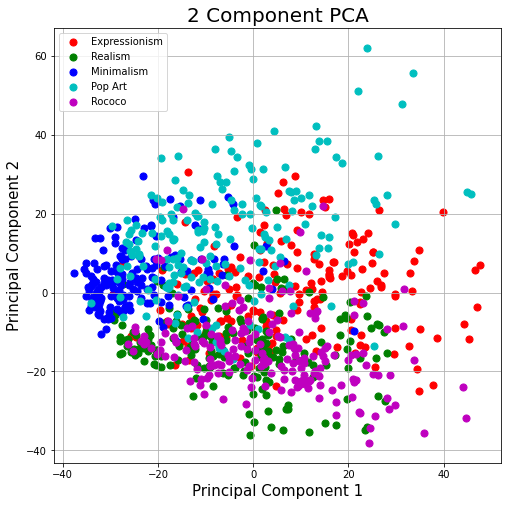

In [0]:
# now for 5 categories per graph
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

colors = ['r', 'g', 'b', 'c', 'm']
for category, color in zip(unique_cats[5:10],colors):
    indicesToKeep = other_df['category'] == category
    ax.scatter(other_df.loc[indicesToKeep, 'principal component 1']
               , other_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(unique_cats[5:10])
ax.grid()

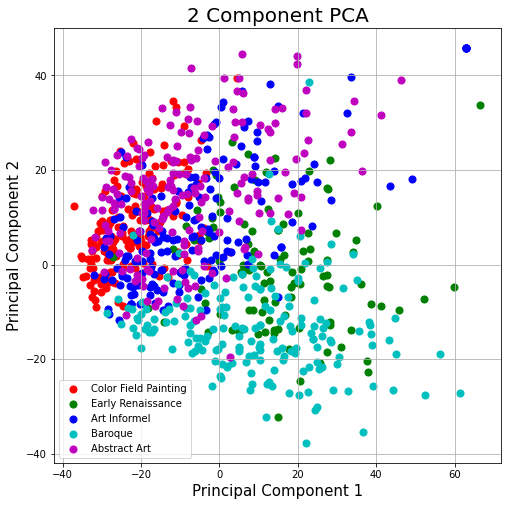

In [0]:
# now for 5 categories per graph
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

colors = ['r', 'g', 'b', 'c', 'm']
for category, color in zip(unique_cats[10:15],colors):
    indicesToKeep = other_df['category'] == category
    ax.scatter(other_df.loc[indicesToKeep, 'principal component 1']
               , other_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(unique_cats[10:15])
ax.grid()

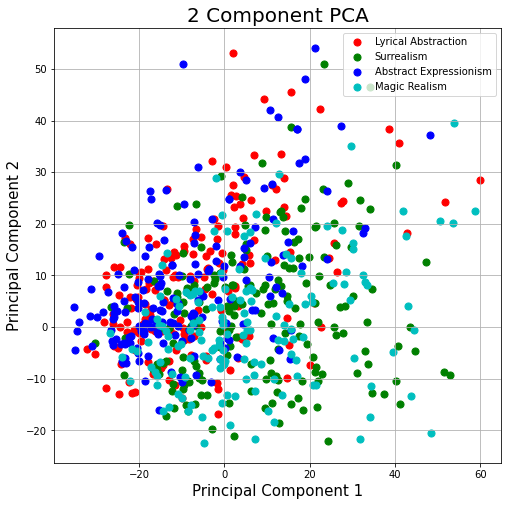

In [0]:
# now for 5 categories per graph
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

colors = ['r', 'g', 'b', 'c', 'm']
for category, color in zip(unique_cats[15:19],colors):
    indicesToKeep = other_df['category'] == category
    ax.scatter(other_df.loc[indicesToKeep, 'principal component 1']
               , other_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(unique_cats[15:19])
ax.grid()

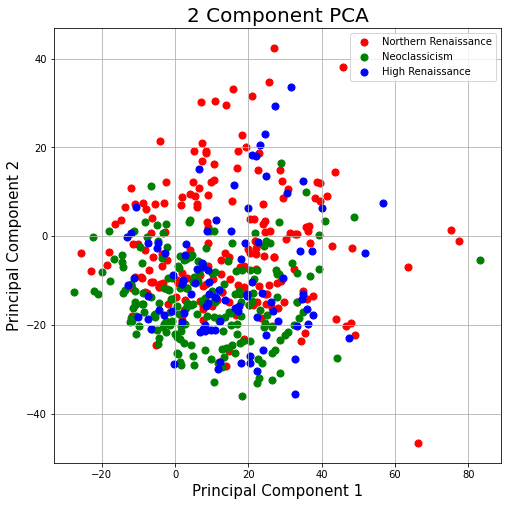

In [0]:
# now for 5 categories per graph
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

colors = ['r', 'g', 'b', 'c', 'm']
for category, color in zip(unique_cats[19:25],colors):
    indicesToKeep = other_df['category'] == category
    ax.scatter(other_df.loc[indicesToKeep, 'principal component 1']
               , other_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(unique_cats[19:25])
ax.grid()

### Comparison
From the PCA visualisation we find that the clusters that cluster 1, 2, 3 and are quite an apparent clusters with lots of points very close to each other, whereas cluster 0 and 4 are quite invisible. 

Comparing cluster 1 to the graphs visualising the existing style clusters, we find that the points from cluster 1 can mostly be found within the styles of renaissance / early rennaisance / baroque / classicism, styles that I would visualy pair together as well. 

The points from cluster 2 can be found in the styles: pop-art, cubism, neo-expressionism, post-impressionism. 

The points from cluster 3 can be found in the styles: minimalism, colorfield painting, abstract art, abstract expressionism. 

That sounds all very logical, with regards to the existing and known similarities in style between these categories (since they appear around the same time in history). 

Now I want to narrow down my dataset to generate artworks on styles that lie closer to each other, I think it's best to choose the renaissance-type works, since these usually tell more of a story. Therefore, I will extract those and create a new list of filenames that contains the files of these clusters. 

### Pickling the filenames of the new cluster. 

In [0]:
labels = np.load('/content/drive/My Drive/AttnGAN/data/wikiart/kmeans_labels.npy')
paths = image_df['path'].tolist()
print(labels)
print(paths)

[1 3 2 ... 3 1 3]
['/impressionism/in-the-luxembourg-garden-1889.jpg', '/neo_expressionism/the-marriage-of-heaven-and-hell-1984.jpg', '/post_impressionism/uncle-piacsek-in-front-of-the-black-sideboard-1906.jpg', '/cubism/monk-for-the-play-mazeppa-1920.jpg', '/romanticism/the-defence-of-sarago-a.jpg', '/expressionism/in-a-village-near-paris-street-in-paris-pink-sky-1909.jpg', '/realism/last-supper.jpg', '/realism/spring-1857.jpg', '/minimalism/mirror-and-crushed-shells-1969.jpg', '/minimalism/one-ton-prop-house-of-cards-1969.jpg', '/pop_art/back-bay-in-bombay-from-the-india-mother-suite-of-7-aquatints-1970.jpg', '/rococo/admiral-john-forbes-1714-1796-1778.jpg', '/color_field_painting/untitled-1968.jpg', '/color_field_painting/toile-d-coup-e-1976.jpg', '/cubism/dances-at-the-spring-1912.jpg', '/early_renaissance/madonna-and-child.jpg', '/art_informel/untitled-1958.jpg', '/expressionism/the-sick-child-1886.jpg', '/minimalism/peinture-relief-1955.jpg', '/neo_expressionism/self-portrait-wit

We want to take out cluster 1, but lets see how big all the clusters are. 

In [0]:
lo_labels = np.ndarray.tolist(labels)

In [0]:
cluster0_paths = []
for i, cluster in enumerate(lo_labels):
  if (cluster == 0):
    cluster0_paths.append(paths[i])

cluster1_paths = []
for i, cluster in enumerate(lo_labels):
  if (cluster == 1):
    cluster1_paths.append(paths[i])

cluster2_paths = []
for i, cluster in enumerate(lo_labels):
  if (cluster == 2):
    cluster2_paths.append(paths[i])

cluster3_paths = []
for i, cluster in enumerate(lo_labels):
  if (cluster == 3):
    cluster3_paths.append(paths[i])

cluster4_paths = []
for i, cluster in enumerate(lo_labels):
  if (cluster == 4):
    cluster4_paths.append(paths[i])

In [0]:
print("cluster 0: ", len(cluster0_paths),
      "\ncluster 1: ", len(cluster1_paths),
      "\ncluster 2: ", len(cluster2_paths),
      "\ncluster 3: ", len(cluster3_paths),
      "\ncluster 4: ", len(cluster4_paths),
      )

cluster 0:  457 
cluster 1:  899 
cluster 2:  764 
cluster 3:  1773 
cluster 4:  1


Poor cluster 4, makes sense that it's not really apparaent in the graph though. 

Now, we have to create a `.pickle` file again that contains the path to all the images in cluster 1 from `/content/drive/My Drive/AttnGAN/data/wikiart/images` ...

In [0]:
import pickle
import random 
import pandas as pd

In [0]:
new_paths = []
for path in cluster1_paths:
  new_path = path.strip('/')[:-4] # the pickle file doesn't need '.jpg' nor the first slash 
  new_paths.append(new_path)

random.shuffle(new_paths)

# 80% = 719 (train), 20% = 180 (test)
train_paths = new_paths[:719]
test_paths = new_paths[719:]

In [0]:
with open('/content/drive/My Drive/AttnGAN/data/wikiart/train/cluster1_filenames.pickle', 'wb') as f:
  pickle.dump(train_paths, f)

with open('/content/drive/My Drive/AttnGAN/data/wikiart/test/cluster1_filenames.pickle', 'wb') as f:
  pickle.dump(test_paths, f)